# Reconocimiento facial por medio de Eigenfaces

**Proyecto Final: Lineal Avanzada**

**Primavera 2020**


El reconocimiento facial es un reto que tiene como propósito clasificar un rostro, por medio de una imagen, la cual, contenga el rostro a clasificar. En particular, la técnica de reconocimiento facial llamada **eigenfaces** tiene como fundamento la reducción de dimensiones por medio del Análisis de Componentes Principales (**PCA**, por sus siglas en inglés).

El PCA se aplica a una colección de imágenes (faciales) para obtener un conjunto de carácteristicas básicas. A las imágenes básicas resultante se les conoce como **imágenes propias**, para reconstruir imágenes en el conjunto de entrenamiento original se utilizan combinaciones linelaes de estas **imágenes propias**. Por ejemplo, si se usan ***m*** imágenes en el conjunto de entrenamiento, del análisis de componentes principales se obtiene un conjunto de tamaño ***n*** (***m*** < ***n*** ) con estas **imágenes propias**.

A continuación implementamos un algoritmo de reconocimiento facial por medio de *eigenfaces*.

Para entrenar al modelo:

1.-Cargamos las imágenes en blanco y negro del conjunto de entrenamiento.

2.-Calculamos la cara promedio (mean face).

3.-Normalizamos el conjunto de entrenamiento: a cada imagen le restamos la media.

4.-Calculamos la matriz de covarianza.

5.-Calculamos los vectores propios de la matriz de covarianza.

6.-Calculamos las caras propias: vectores propios x imágenes normalizadas.

7.-Elegimos las caras propias más significativas.

8.-Calculamos pesos: caras propias elegidas x imágenes normalizadas.


Vemos la imagen de una cara como una matriz de imagen con dimensión $[m x n]$. Convertimos cada matriz en un vector de imagen con dimensión $[(m x n) x 1]$. 

Por lo tanto, cada cara se puede representar como un vector y todo el conjunto de caras representará un espacio vectorial de dimensión m x n x N, donde N es el número de imágenes de todas las caras. 

Si tomamos una imagen del conjunto de prueba, podemos asignarla a un espacio creado previamente y determinar a qué imagen de la muestra de entrenamiento se encuentra nuestro ejemplo más cercano. Si se encuentra a una distancia relativamente grande de todos los datos, es más probable que esta imagen no pertenezca a nuestra base de datos. Después de aplicar el siguiente algoritmo, vemos que los primeros 24 componentes contienen casi el 100% de la información. 

# Implementación

In [169]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

## Cargamos la data

Indicamos los directorios de las imágenes de entrenamiento y prueba

In [170]:
TRAIN_IMG_FOLDER = '/Users/claudiameneses/Desktop/lineal/PCA-ReconocimientoFacial/images1/Training images/'
TEST_IMG_FOLDER = '/Users/claudiameneses/Desktop/lineal/PCA-ReconocimientoFacial/images1/Test/'

train_set_files = os.listdir(TRAIN_IMG_FOLDER)
test_set_files = os.listdir(TEST_IMG_FOLDER)

width  = 128
height = 128

Consultamos el directorio, luego tomamos como id la primer parte del nombre de cada imágen y queremos verificar que el tamaño del conjunto de entrenamiento sea mayor o igual que el tamaño del conjunto de prueba.

In [171]:
train_id_file = set([f.split('_')[0] for f in train_set_files])
test_id_file = set([f.split('_')[0] for f in train_set_files])
print(train_id_file <= test_id_file)

True


Train Images:


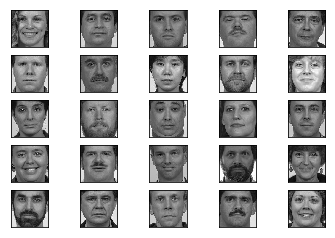

Test Images:


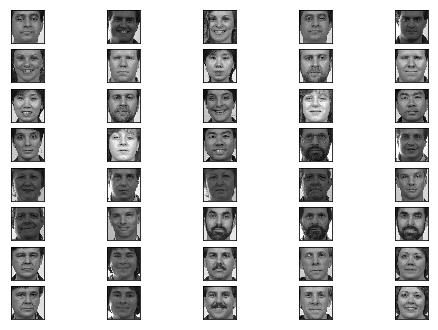

In [172]:
print('Train Images:')
train_image_names = os.listdir(TRAIN_IMG_FOLDER) #lista de nombres de img del dir
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64) #definimos el tensor

#leemos la imágenes, las guardamos en el tensor y las mostramos

for i in range(len(train_image_names)):
    img = plt.imread(TRAIN_IMG_FOLDER + train_image_names[i])
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(5,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

print('Test Images:')
test_image_names = os.listdir(TEST_IMG_FOLDER)
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(TEST_IMG_FOLDER + test_image_names[i])
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(8,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Calculamos "the mean face"

La media es la suma de todas las imágenes dividida entre el número de imágenes, es decir, una cara "promedio"

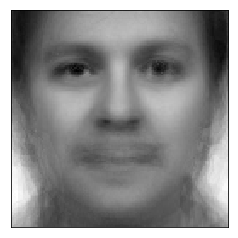

In [173]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)
    
mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Calculamos la diferencia entre el vector de entrenamiento y el promedio

Queremos normalizar el conjunto de imágenes de entrenamiento, para esto, a cada imágen del conjunto de entrenamiento le restamos la cara "promedio" calculada en el paso anterior.

Este paso se realiza con el fin de que se pueda representar cualquier cara. Por lo que calculamos elemento que todas las caras. tienen en común, al restar esta media de las imágenes los rasgos que distinguen a cada cara son más evidentes.

In [174]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)

## Caras normalizadas

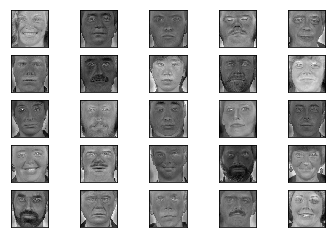

In [175]:
for i in range(len(train_image_names)):
    img = normalised_training_tensor[i].reshape(height,width)
    plt.subplot(5,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Matriz de covarianza

La covarianza nos dice como cambian dos variables juntas. Las imágenes anteriores tienen diferentes características y queremos ver como cambian estas caracteristicas para cada imágen en comparación con el resto de las imágenes.

In [176]:
cov_matrix=np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix,25.0)
print('Dimensiones de la matriz de covarianza:', cov_matrix.shape)

Dimensiones de la matriz de covarianza: (25, 25)


## Eigenvectores de covarianza

Calculamos, los eigenvectores de la matriz de covarianza. Los eigenvetores de la covarianza nos ayudan a describir la dirección de la data.

In [177]:
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
print('Dimensiones de los eigenvalores: {} Dimensiones de los eigenvectores: {}'.format(eigenvalues.shape, eigenvectors.shape))

Dimensiones de los eigenvalores: (25,) Dimensiones de los eigenvectores: (25, 25)


In [178]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]
#Ordenamos los eigenpares in orden descendente 
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

sorted_ind = sorted(range(eigenvalues.shape[0]), key=lambda k: eigenvalues[k], reverse=True)

eigvalues_sort = eigenvalues[sorted_ind]
eigvectors_sort = eigenvectors[sorted_ind]
train_set_files_sort = np.array(train_set_files)[sorted_ind]

## Encontramos la varianza acumulada para cada componente principal

Proporción de la varianza acumulada exlicada por componentes principales: 
[0.28481989 0.41576165 0.49714907 0.55777059 0.60785024 0.65427472
 0.69489721 0.73168527 0.7641529  0.7916646  0.81546473 0.83669985
 0.85752859 0.87642433 0.89418977 0.91069532 0.92659352 0.94017913
 0.95309028 0.96500642 0.97612862 0.98491526 0.99275274 1.
 1.        ]


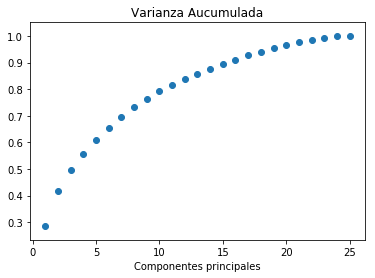

In [179]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Varianza acumulada respecto a los componentes principales
print("Proporción de la varianza acumulada exlicada por componentes principales: \n%s" %var_comp_sum)

num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Varianza Aucumulada')
plt.xlabel('Componentes principales')

plt.scatter(num_comp, var_comp_sum)
plt.show()

In [180]:
reduced_data = np.array(eigvectors_sort[:15]).transpose()
print(reduced_data.shape)
print(eigvectors_sort.shape)

(25, 15)
(25, 25)


In [181]:
print(training_tensor.transpose().shape, reduced_data.shape)

(16384, 25) (25, 15)


## Calculamos las eigenfaces

Cada eigenvector se multiplica por la matriz del conjunto de entrenamiento ya normalizada, lo que da como resultado la misma cantidad de eigenfaces e imagenes de nuestro conjunto de entrenamiento.

In [182]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()
proj_data.shape

(15, 16384)

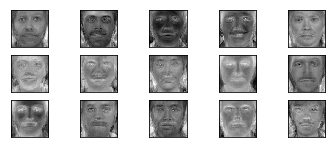

In [183]:
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height,width)
    plt.subplot(5,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Buscamos los pesos para cada imagen del conjunto de entrenamiento

Cada cara normalizada del conjunto de entrenamiento multiplica cada eigenface. En consecuencia, habrá un conjunto de N pesos (cant de imágenes en el conjunto de entrenamiento) con M elementos (número de eigenfaces).

In [184]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
print(w.shape)

(25, 15)


# Reconocimiento de la imágenes de prueba

In [185]:
def recogniser(test_image_names, train_image_names,proj_data,w, t0=2e8, prn=False):
    count        = 0
    num_images   = 0
    correct_pred = 0
    
    result = []
    wts = []
    
    #False match rate (FMR)
    FMR_count = 0
    
    #False non-match rate (FNMR)
    FNMR_count = 0
     

    test_image_names2 = sorted(test_image_names)

    for img in test_image_names2:

        unknown_face = plt.imread(TEST_IMG_FOLDER+img)
        num_images += 1
        
        unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
        normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

        w_unknown = np.dot(proj_data, normalised_uface_vector)
        diff  = w - w_unknown
        norms = np.linalg.norm(diff, axis=1)
        index = np.argmin(norms)
        
        wts.append([count, norms[index]])

        if prn: print('Input:'+'.'.join(img.split('.')[:2]), end='\t')
        count+=1
        
        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        if norms[index] < t0: # It's a face
            if match:
                if prn: print('Matched:' + train_image_names[index], end = '\t')
                correct_pred += 1
                result.append(1)
            else:
                if prn: print('F/Matched:'+train_image_names[index], end = '\t')
                result.append(0)
                FMR_count += 1
        else:
            if match:
                if prn: print('Unknown face!'+train_image_names[index], end = '\t')
                FNMR_count +=1
                
            else:
                pass
                correct_pred += 1



        if prn: print(norms[index], end=' ')
        if prn: print()
            
            
    
    FMR = FMR_count/num_images
    FNMR = FNMR_count/num_images
    
    
    print('Predicciones correctas: {}/{} = {} \t\t'.format(correct_pred, num_images, correct_pred/num_images), end=' ')
    print('FMR: {} \t'.format(FMR), end=' ')
    print('FNMR: {} \t'.format(FNMR))
    
    
    
    return wts, result, correct_pred, num_images, FMR, FNMR
    

wts, result, correct_pred, num_images, FMR, FNMR =recogniser(test_image_names, train_image_names,proj_data,w, t0=2e8, prn=True)

Input:00770_960530_fa.jpg	Matched:00770_960530_fa.jpg	0.0 
Input:00770_960530_fa_a.jpg	F/Matched:00744_941201_fa.jpg	27999207.090321355 
Input:00771_941205_fa.jpg	Matched:00771_941205_fa.jpg	0.0 
Input:00771_941205_fb.jpg	Matched:00771_941205_fa.jpg	10897963.82860674 
Input:00772_941201_fa.jpg	Matched:00772_941201_fa.jpg	0.0 
Input:00772_941201_fb.jpg	F/Matched:00763_941201_fa.jpg	14812108.239029266 
Input:00773_941201_fa.jpg	Matched:00773_941201_fa.jpg	0.0 
Input:00773_941201_fb.jpg	F/Matched:00794_941205_fa.jpg	15965625.738617796 
Input:00775_941205_fa.jpg	Matched:00775_941205_fa.jpg	0.0 
Input:00775_941205_fb.jpg	Matched:00775_941205_fa.jpg	5798627.751248544 
Input:00779_941205_fa.jpg	Matched:00779_941205_fa.jpg	0.0 
Input:00779_941205_fb.jpg	Matched:00779_941205_fa.jpg	30032213.374017157 
Input:00781_941205_fa.jpg	Matched:00781_941205_fa.jpg	0.0 
Input:00781_941205_fb.jpg	F/Matched:00804_941205_fa.jpg	8478790.600640602 
Input:00787_941205_fa.jpg	Matched:00787_941205_fa.jpg	0.0 
Inp

# Resultados de la predicción

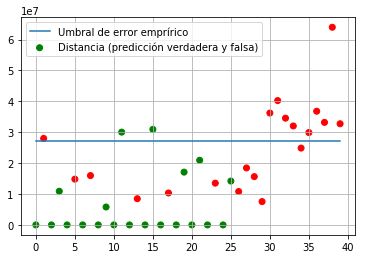

In [186]:
def rg(r):
    if r: return 'g'
    else: return 'r'
cl = [rg(r) for r in result]

x=[x[0] for x in wts]
y=[y[1] for y in wts]
plt.scatter(x,y, color=cl, label = 'Distancia (predicción verdadera y falsa)')

x2=[x[0] for x in wts]
y2=[2.7e7 for y in wts]

plt.plot(x2,y2, label = 'Umbral de error emprírico')
plt.legend()
plt.grid()

plt.show()


In [187]:
CPR_list, t0_list, FMR_list, FNMR_list = [], [] , [] , []
for t0 in np.linspace(start=0, stop=1e8, num=20):
    print('{:e}'.format(t0), end=' ')
    wts, result, correct_pred, num_images, FMR, FNMR = recogniser(test_image_names, train_image_names,proj_data,w, t0)
    
    CPR_list.append(correct_pred/num_images) 
    t0_list.append(t0)
    FMR_list.append(FMR)
    FNMR_list.append(FNMR)

0.000000e+00 Predicciones correctas: 20/40 = 0.5 		 FMR: 0.0 	 FNMR: 0.5 	
5.263158e+06 Predicciones correctas: 33/40 = 0.825 		 FMR: 0.0 	 FNMR: 0.175 	
1.052632e+07 Predicciones correctas: 31/40 = 0.775 		 FMR: 0.075 	 FNMR: 0.15 	
1.578947e+07 Predicciones correctas: 29/40 = 0.725 		 FMR: 0.175 	 FNMR: 0.1 	
2.105263e+07 Predicciones correctas: 29/40 = 0.725 		 FMR: 0.225 	 FNMR: 0.05 	
2.631579e+07 Predicciones correctas: 28/40 = 0.7 		 FMR: 0.25 	 FNMR: 0.05 	
3.157895e+07 Predicciones correctas: 28/40 = 0.7 		 FMR: 0.3 	 FNMR: 0.0 	
3.684211e+07 Predicciones correctas: 22/40 = 0.55 		 FMR: 0.45 	 FNMR: 0.0 	
4.210526e+07 Predicciones correctas: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
4.736842e+07 Predicciones correctas: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
5.263158e+07 Predicciones correctas: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
5.789474e+07 Predicciones correctas: 21/40 = 0.525 		 FMR: 0.475 	 FNMR: 0.0 	
6.315789e+07 Predicciones correctas: 21/40 = 0.525 		 FMR: 0.4

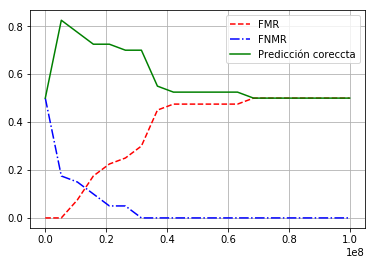

In [188]:
x1=t0_list
y1=FMR_list

x2=t0_list
y2=FNMR_list

x3=t0_list
y3=CPR_list

plt.plot(x1,y1, ls='--', color='r', label='FMR',)
plt.plot(x2,y2, ls='-.', color='b', label='FNMR')
plt.plot(x3,y3, color='g', label='Predicción coreccta')

plt.grid()
plt.legend()

## Resultados predichos en todas las imágenes de prueba

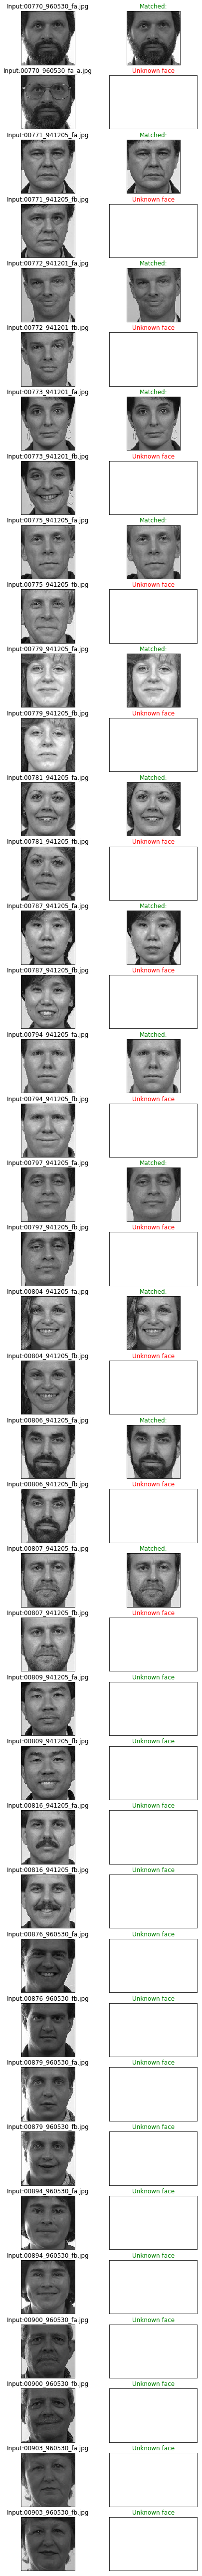

In [189]:
count        = 0
num_images   = 0
correct_pred = 0
def Visualization(img, train_image_names,proj_data,w, t0):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread(TEST_IMG_FOLDER+img)
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(40,2,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
   

    
    plt.subplot(40,2,1+count)
    if norms[index] < t0: # It's a face
            
        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        #if img.split('.')[0] == train_image_names[index].split('.')[0]:
        if match:
            #plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
            plt.title('Matched:', color='g')
            plt.imshow(imread(TRAIN_IMG_FOLDER+train_image_names[index]), cmap='gray')
                
            correct_pred += 1
        else:
            #plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
            plt.title('False matched:', color='r')
            plt.imshow(imread(TRAIN_IMG_FOLDER+train_image_names[index]), cmap='gray')
    else:
        #if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
        if img.split('_')[0] not in [i.split('_')[0] for i in train_image_names]:
            plt.title('Unknown face', color='g')
            correct_pred += 1
        else:
            plt.title('Unknown face', color='r')
                
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.subplots_adjust(right=1.2, top=2.5)
   
    count+=1

    
fig = plt.figure(figsize=(5, 30))

test_image_names2 = sorted(test_image_names)
for i in range(len(test_image_names2)):
    Visualization(test_image_names2[i], train_image_names,proj_data,w, t0=5.26e6)

plt.show()